In [1]:
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import numpy as np
import urllib3
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont
import pandas as pd

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
import plotting
import processing

In [3]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'

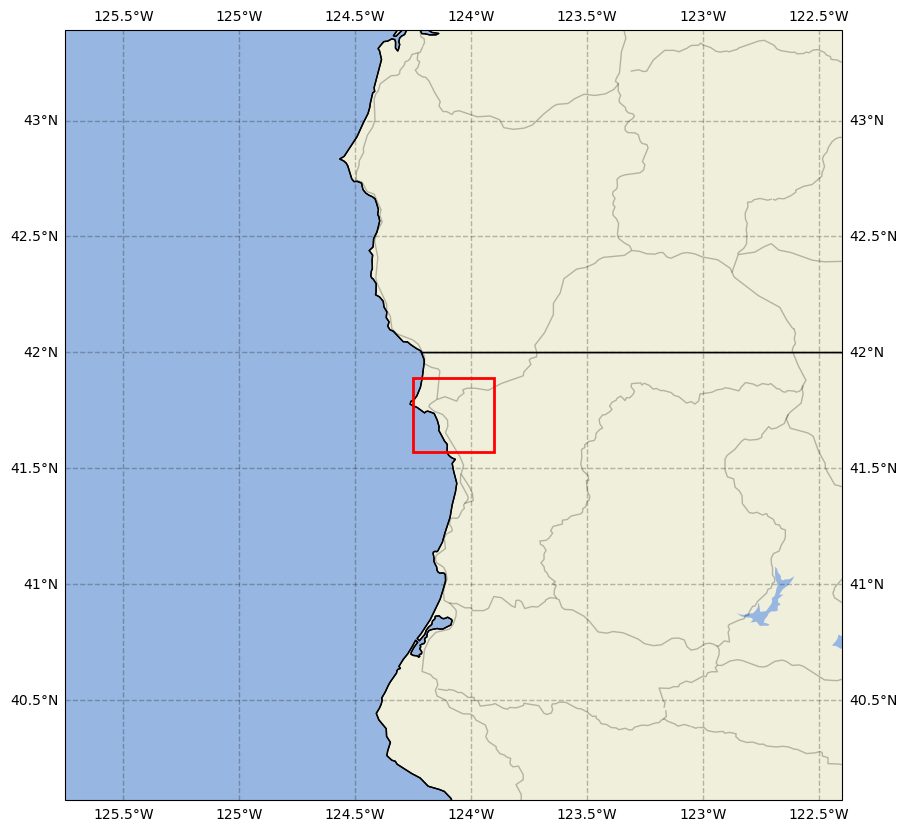

In [4]:
redwood_bb = dict(min_lon=-124.25, min_lat=41.57, max_lon=-123.90, max_lat=41.89)
redwood_start = datetime(2022, 9, 1)
redwood_sample = datetime(2022, 9, 20)
redwood_end = datetime(2022, 9, 30)

plotting.map_box(redwood_bb, padding=1.5)

In [5]:
PRECIP_DS = 'GPM_3IMERGDL_precipitationCal'
PRECIP_CLIM_DS = 'GPM_3IMERGDL_precipitationCal_clim'
SM_DS = 'SPL3SMP_PM_soil_moisture'
CO2_DS = ''

## Precipitation

In [6]:
precip_subset = processing.data_subsetting(PRECIP_DS, redwood_bb, redwood_sample, redwood_sample, )

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=GPM_3IMERGDL_precipitationCal&b=-124.25%2C41.57%2C-123.9%2C41.89&startTime=2022-09-20T00%3A00%3A00Z&endTime=2022-09-20T00%3A00%3A00Z

Waiting for response...
took 0.18075779199716635 seconds


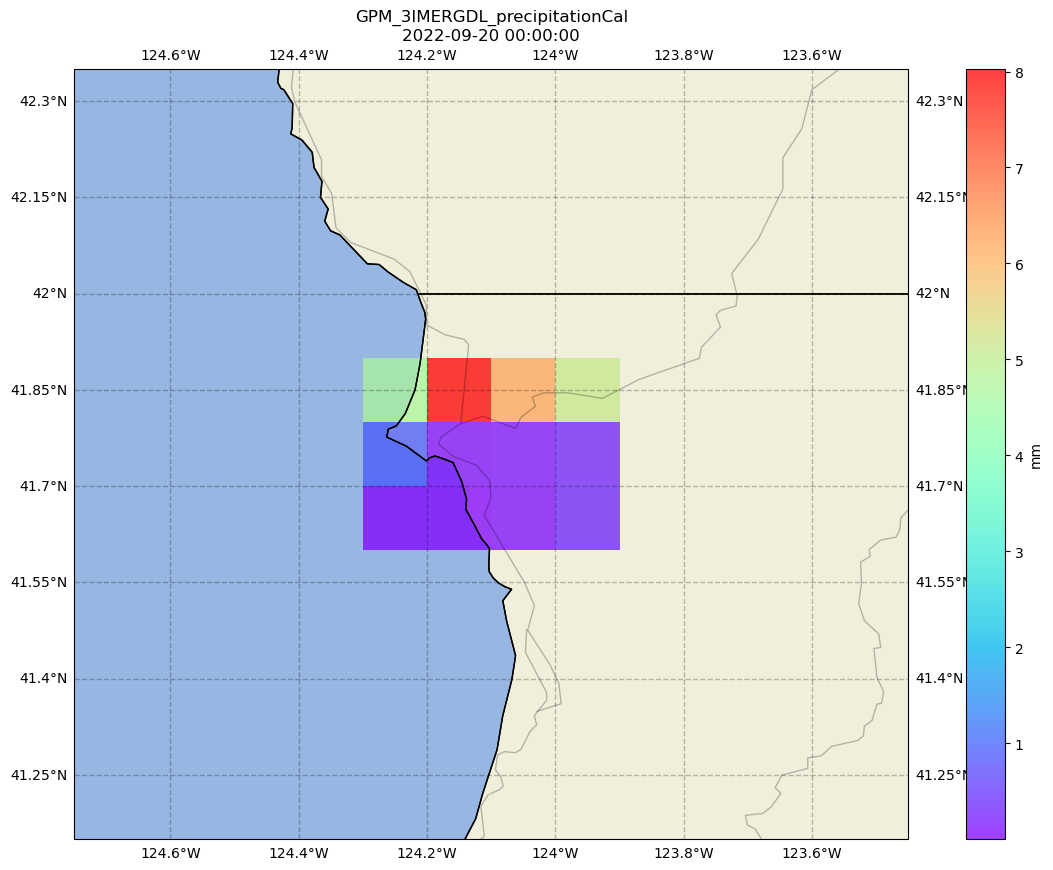

In [7]:
plotting.map_data(precip_subset[0], f'{PRECIP_DS}\n{redwood_sample}', padding=.5, cb_label='mm')

In [8]:
precip_ts = processing.spatial_timeseries(PRECIP_DS, redwood_bb, redwood_start, redwood_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM_3IMERGDL_precipitationCal&minLon=-124.25&minLat=41.57&maxLon=-123.9&maxLat=41.89&startTime=2022-09-01T00%3A00%3A00Z&endTime=2022-09-30T00%3A00%3A00Z&lowPassFilter=False

Waiting for response...
took 7.936803167001926 seconds


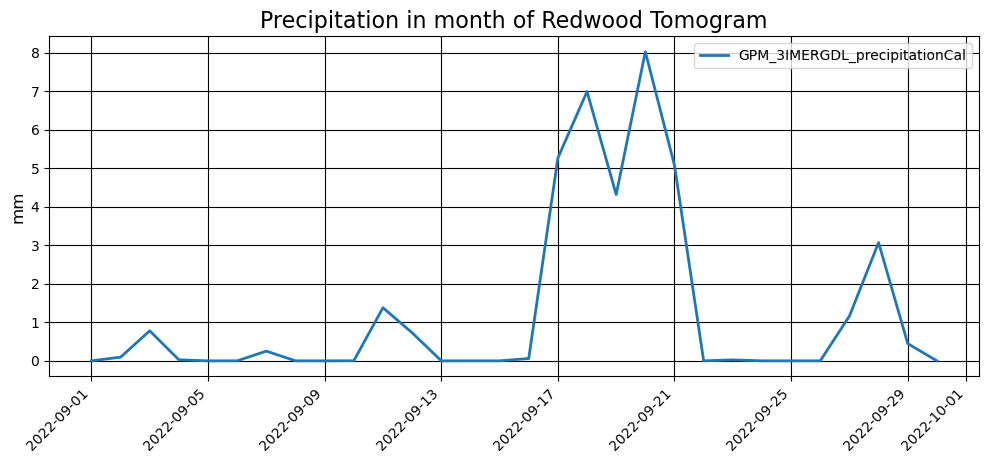

In [9]:
plotting.timeseries_plot(
    [(precip_ts['maximum'], PRECIP_DS)],
    '', 
    'mm', 
    'Precipitation in month of Redwood Tomogram', 
    norm=False
)

In [10]:
precip_daily_diff = processing.daily_diff(PRECIP_DS, PRECIP_CLIM_DS, redwood_bb, redwood_start, redwood_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/dailydifferenceaverage_spark?dataset=GPM_3IMERGDL_precipitationCal&climatology=GPM_3IMERGDL_precipitationCal_clim&b=-124.25%2C41.57%2C-123.9%2C41.89&startTime=2022-09-01T00%3A00%3A00Z&endTime=2022-09-30T00%3A00%3A00Z

Waiting for response... 
took 0.8689220829983242 seconds


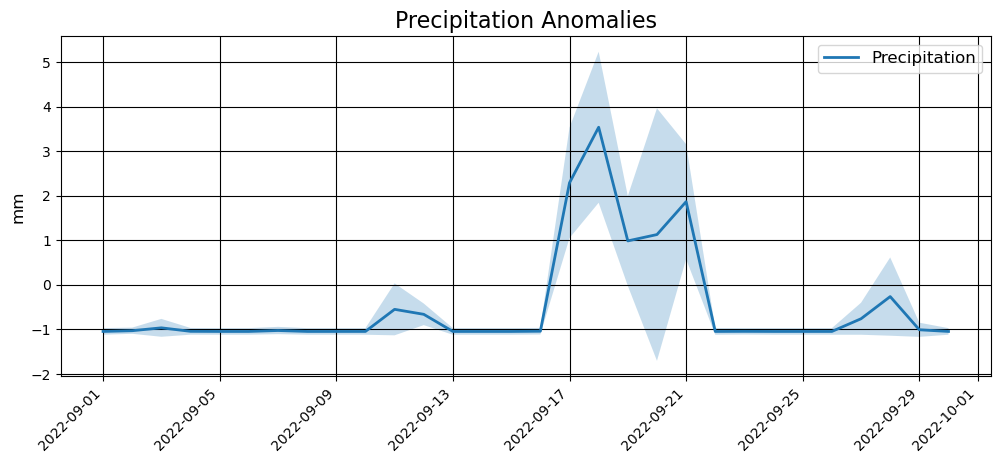

In [11]:
plotting.timeseries_bands_plot(precip_daily_diff, 'Precipitation', '', 'mm', 'Precipitation Anomalies')

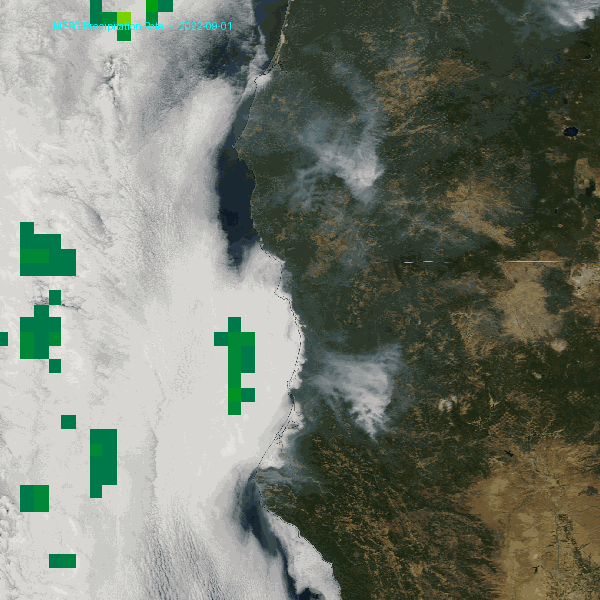

In [12]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(0,255,255)'
stroke_color = 'rgb(0,255,255)'
frames = []

padding = 2

dates = pd.date_range(redwood_start,redwood_end-timedelta(days=1),freq='d')

bbox = tuple([a + b for a, b in zip(redwood_bb.values(), [-padding, -padding, padding, padding])])

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=bbox,  # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color, stroke_fill=stroke_color)
    frames.append(image)

frames[0].save('/tmp/IMERG_Precipitation_Rate_Redwood.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('/tmp/IMERG_Precipitation_Rate_Redwood.gif')

## Soil Moisture

This section uses a large bounding box and the whole of 2022 due to data resolution and availability.

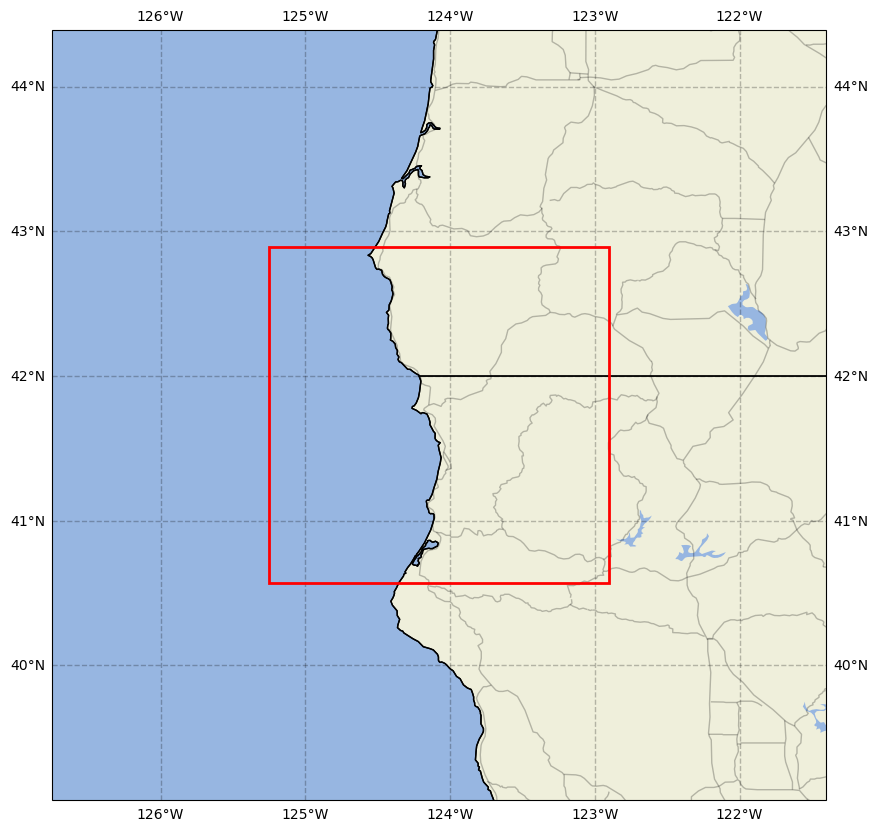

In [13]:
redwood_sm_bb = dict(min_lon=-125.25, min_lat=40.57, max_lon=-122.90, max_lat=42.89)

plotting.map_box(redwood_sm_bb, padding=1.5)

In [14]:
sm_subset = processing.data_subsetting(SM_DS, redwood_sm_bb, datetime(2022,1,1), datetime(2022,12,31), )

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=SPL3SMP_PM_soil_moisture&b=-125.25%2C40.57%2C-122.9%2C42.89&startTime=2022-01-01T00%3A00%3A00Z&endTime=2022-12-31T00%3A00%3A00Z

Waiting for response...
took 4.224281916001928 seconds


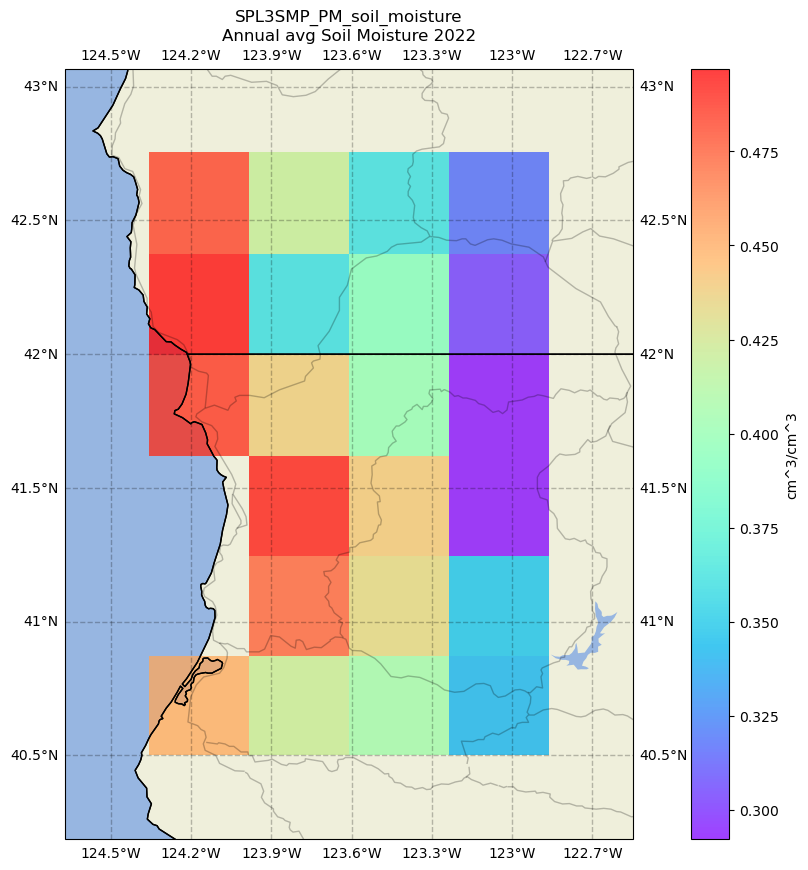

In [15]:
plotting.map_data(sm_subset.mean('time'), f'{SM_DS}\nAnnual avg Soil Moisture 2022', padding=.5, cb_label='cm^3/cm^3')

In [16]:
sm_ts = processing.spatial_timeseries(SM_DS, redwood_sm_bb, redwood_start, redwood_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=SPL3SMP_PM_soil_moisture&minLon=-125.25&minLat=40.57&maxLon=-122.9&maxLat=42.89&startTime=2022-09-01T00%3A00%3A00Z&endTime=2022-09-30T00%3A00%3A00Z&lowPassFilter=False

Waiting for response...
took 0.23694516600153293 seconds


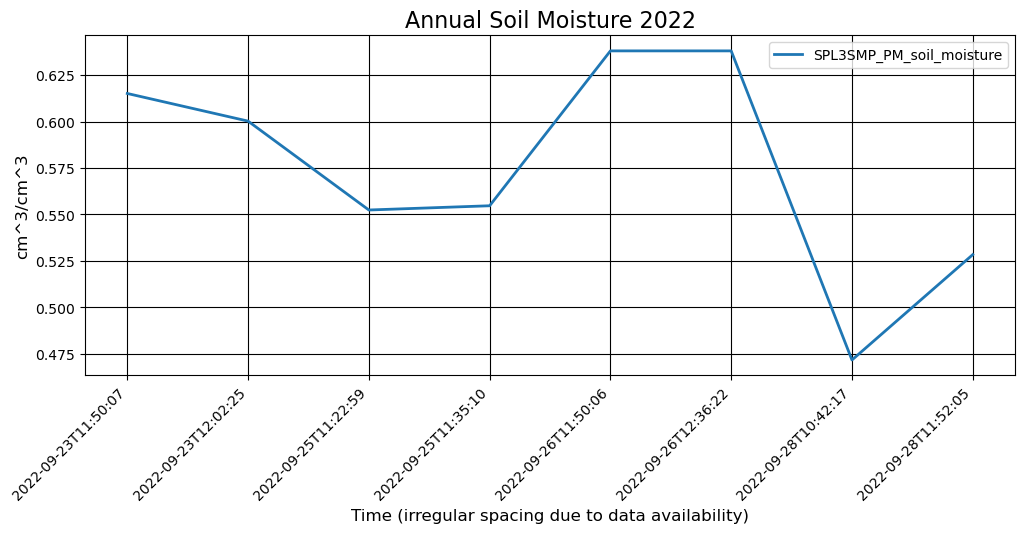

In [17]:
plotting.timeseries_plot_irregular(
    [(sm_ts['maximum'], SM_DS)],
    'Time (irregular spacing due to data availability)', 
    'cm^3/cm^3', 
    'Annual Soil Moisture 2022', 
    norm=False
)